In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import pandas as pd
from descartes import PolygonPatch
ox.config(use_cache=True, log_console=True)

In [2]:
place = 'Monash University, Clayton Campus'

In [3]:
# geocode place name to lat-lng
monash_latlng = ox.geocode(place)

# alternatively, get GeoDataFrame from place name
monash_gdf = ox.gdf_from_place(place)

In [4]:
# get 100 sq km of surrounding street network as graph from OSM
G = ox.graph_from_point(monash_latlng, distance=5000, network_type='drive', truncate_by_edge=True)

In [5]:
# make a 25 sq km bounding box to visually inspect
bbox = ox.bbox_from_point(monash_latlng, 2500)

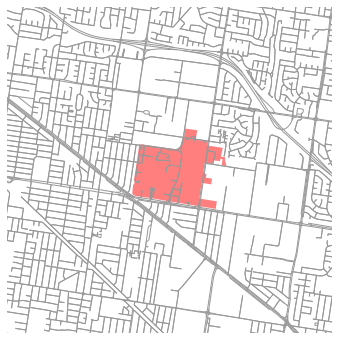

In [6]:
# plot the network
fig, ax = ox.plot_graph(G, bbox=bbox, node_size=0, show=False, close=False)

# plot the campus
polygon = monash_gdf.loc[0, 'geometry']
ax.add_patch(PolygonPatch(polygon, fc='r', linewidth=0, alpha=0.5))
plt.show()

In [7]:
# find the network node nearest the campus centroid, and pick another random node
orig = ox.get_nearest_node(G, monash_latlng)
dest = list(G.nodes())[400]

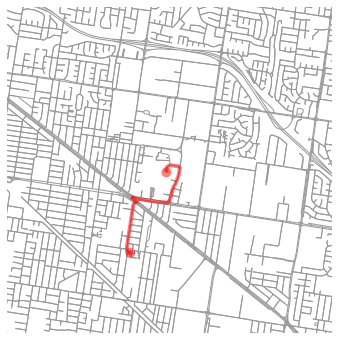

In [8]:
route = nx.shortest_path(G, orig, dest, 'length')
fig, ax = ox.plot_graph_route(G, route, bbox=bbox, node_size=0)

In [ ]:
# calculate each node's distance from campus along the network
nd = {}
for n in G.nodes():
    try:
        nd[n] = nx.shortest_path_length(G, orig, n, 'length')
    except:
        nd[n] = None

In [ ]:
# plot network nodes by distance to campus
nx.set_node_attributes(G, nd, 'dist')
nc = ox.get_node_colors_by_attr(G, 'dist', cmap='plasma_r')
bbox = ox.bbox_from_point(monash_latlng, 5000)
fig, ax = ox.plot_graph(G, bbox=bbox, node_color=nc, node_zorder=2)

## Make a leaflet web map of the central part of the network

In [ ]:
# induce a subgraph within 3km of the center
subset = [n for n, d in G.nodes(data=True) if pd.notnull(d['dist']) and d['dist'] < 3000]
G2 = ox.induce_subgraph(G, subset)

In [ ]:
# make web map and save as html file
l = ox.plot_graph_folium(G2, popup_attribute='name')
l.save('leaflet.html')